In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import os

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import itertools as it
import random
import math
import qutip
import pydot
import cmath
import scipy.linalg as splin
import warnings

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# Quantum Variational Classifier 

This program implements and tests the [Havlíček et al. (2018)](10.1038/s41586-019-0980-2) variational quantum classifier. The algorithm takes on the original supervised learning problem: we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \subset {\rm I\!R}^d$. Both are assumed to be labeled by a map $m$: $T \cup S \longrightarrow \{+1,-1\}$ unknown to the algorithm. The goal is to approximate the map $\tilde{m}: S \rightarrow \{+1,-1\}$ such that is agrees with high probability with the true map $m(\textbf{s}) = \tilde{m}(\textbf{s})$ on the test data $\textbf{s} \in S$. 

### 0. Helper Functions and Testing

In [2]:
n = 2 # num qubits
qs = [cirq.GridQubit(i, 0) for i in range(n)]
pauli_z = np.array([[1,0],[0,-1]] , dtype=float) # Pauli-Z
pauli_y = np.array([[0,-1j],[1j,0]], dtype=complex) # Pauli-Y
I = np.eye(n) # Identity
H = cirq.H # Hadamard

In [3]:
def Ry(theta):
    return np.array([[cmath.cos(theta/2.), -1*cmath.sin(theta/2.)], 
                     [cmath.cos(theta/2.), cmath.sin(theta/2.)]])

def Rz(theta):
    return np.array([[cmath.exp(-1j*theta/2), 0],
                     [0, cmath.exp(1j*theta/2)]])

In [4]:
# from numpy source code: this is their unitary check
def is_unitary(matrix: np.ndarray, *, rtol: float = 1e-5, atol: float = 1e-8) -> bool:
    return (matrix.shape[0] == matrix.shape[1] and
    np.allclose(matrix.dot(np.conj(matrix.T)),
    np.eye(matrix.shape[0]),
    rtol=rtol,
    atol=atol))

In [5]:
flatten = lambda t: [item for sublist in t for item in sublist]
expand = lambda a: np.array([list(a)]*10)

In [6]:
# all sub-lists must be of equal length
def lst_average(lst):
    N = len(lst)
    m = len(lst[0])
    new = [0]*m
    for i in range(N):
        for j in range(m):
            new[j] += lst[i][j]
    return [x/N for x in new]

In [7]:
def regex_complex(U):
    str_U = str(U)
    regex = re.compile(r'(\d.\s+(-|\+)\d.\d?j|-?\d.\d*\s?(-|\+)\d.\d*j)')
    nums = regex.findall(str_U)

    complex_array = []
    for i, n in enumerate(nums):
        complex_array.append(complex(n[0].replace(' ', '')))
    
    complex_array = np.array(complex_array)
    return complex_array.reshape((4,4))

In [8]:
def powerset_help(S):
    x = len(S)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, S) if i & mask]
        
def powerset(S, mx):
    return [l for l in list(powerset_help(S)) if len(l) <= mx]

In [9]:
def kron(*elts):
    res = 1
    for e in elts:
        res = np.kron(res,e)
    return res

## 1. Construct non-trivial data encoding feature map with entanglement $\left| \Phi(x_i) \right\rangle \left\langle \Phi(x_i) \right|  $

The feature map is an injective encoding of the classical data $\textbf{x} \in {\rm I\!R}^d$ into a quantum state $\left| \Phi \right\rangle \left\langle \Phi \right|$. We use the following unitary feature map onto $n$-qubits, where $H$ denotes the conventional Hadamard gate:

$$\left|\Phi(\textbf{x})\right\rangle = \mathcal{U}_{\Phi(\textbf{x})}\left|0\right\rangle^{\otimes n} = U_{\Phi(\textbf{x})}H^{\otimes n} U_{\Phi(\textbf{x})}H^{\otimes n} \left|0\right\rangle^{\otimes n}$$
where,
$$U_{\Phi(\textbf{x})} = \exp\bigg(i \sum_{S \subseteq [n]} \phi_S(\textbf{x}) \prod_{i \in S} Z_i \bigg)$$
where the $2^n$ coefficients $\phi(\textbf{x}) \in {\rm I\!R}$ are now non-linear functions of the input data $\textbf{x} \in {\rm I\!R}^n$. In general, maps with low degree expansions $|S| \leq d$ can be implemented efficiently. As in the original paper, we will use $n=d=2$.

In [10]:
# returns a matrix that applies the 1-qubit matrix U to the qubits indexed by ns (a list)
# does nothing to the other qubits
def U_apply(U, ns, n_qubits):
    U_n = 1
    for i in range(n_qubits-1, -1, -1): #n_qubits-1 -> 0, inclusive
        U_n = np.kron(U_n, U if (i in ns) else I)
    return U_n

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

In [11]:
# each term of phi_S in sum
def phi(S,x):
    if len(S) == 2:
        return (np.pi - x[S[0]])*(np.pi-x[S[1]])
    elif len(S) == 1:
        return x[S[0]]
    elif len(S) == 0:
        return 0
    else:
        assert False, "expected |S|<=2"

In [12]:
# 2^n x 2^n Block diagonal unitary for x
def u_phi(x, n, S_size):
    ss = powerset(np.arange(n), S_size)
    total = np.zeros((2**n,2**n))
    for s in ss:
        total += phi(s, x)*U_apply(pauli_z,s,n)
    u = np.exp(1j*total)
    u = np.diag(np.diag(u))
    return u

In [13]:
def random_x_input(n):
    return [random.random()*2*np.pi for i in range(n)]

In [14]:
def u_gate(x, n):
    return u_phi(x, n, 2)

In [15]:
# given matrix, create equivalent circuit using only operations from tfq.util.get_supported_gates()
def synthesized_circuit(matrix):
    synthesized_operations = cirq.two_qubit_matrix_to_operations(
    cirq.GridQubit(0,0),
    cirq.GridQubit(1,0),
    matrix,
    allow_partial_czs=False,
    )
    
    synth_circuit = cirq.Circuit(synthesized_operations)
    
    synthesized_matrix = cirq.unitary(synth_circuit)

    cirq.testing.assert_allclose_up_to_global_phase(
        matrix,
        synthesized_matrix,
        atol=1e-2
    )
    
    return synth_circuit

In [16]:
# two-qubit feature map with d=2
def feature_map(x, n, d=2):
    circuit = cirq.Circuit()
    u_gate_matrix = u_gate(x, n)
    synth_circuit = synthesized_circuit(u_gate_matrix)
    for _ in range(d):
        circuit.append([H(q) for q in qs], strategy=cirq.InsertStrategy.INLINE)
        circuit.append(synth_circuit)
    return circuit

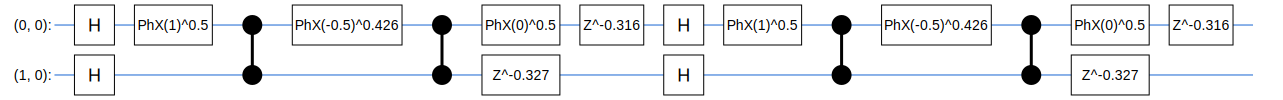

In [17]:
# print out resulting feature map circuit for a random test input
test_input = random_x_input(n)
feature_map_circuit = cirq.Circuit()
feature_map_circuit.append(feature_map(test_input, n))
SVGCircuit(feature_map_circuit)

## 2. Construct short-depth discriminator circuit $W(\theta)$

The general short-depth circuit to define a seperating hyperplane is comprised of the following sequence of single qubit and multi-qubit gates:

$$ W(\theta) = U_{loc}^{(l)}(\theta_l)U_{ent}...U_{loc}^{(2)}(\theta_2)U_{ent}U_{loc}^{(1)}(\theta_1) $$


We apply a circuit of $l$ repeated entanglers and interleave them with layers comprised of local single qubit rotations:

$$ U_{loc}^{(t)}(\theta_t) = \otimes_{m=1}^n U(\theta_{m,t}) \quad \text{and} \quad U(\theta_{m,t}) = \exp\bigg(i \frac{1}{2}\theta_{m,t}^z Z_m\bigg) \exp\bigg(i \frac{1}{2}\theta_{m,t}^y Y_m\bigg) $$

parameterized by $\theta_t \in {\rm I\!R}^{2n}$ and $\theta_{i,t} \in {\rm I\!R}^{2}$. For the feature map that we consider, we use entangling unitaries comprised of products of controlled-Z phase gates $CZ(i,j)$ between qubits $i$ and $j$. The entangling interations follow the interaction graph that $G=(E,V)$ that we used to generate the feature map.

$$ U_{ent} = \prod_{(i,j) \in E} CZ(i,j) $$ 

In [18]:
# local single-qubit rotations
def U_loc(theta, n, t, qs, layer):
    #circuit = cirq.Circuit()
    #y_angles = []
    #z_angles = []
    for m in range(n):
        for i in range(t):
            if (m % 2 == 0):
                #y_angles.append(theta[4*layer+2*m+i])
                yield cirq.ry(theta[4*layer+2*m+i]).on(qs[m])
            else:
                #z_angles.append(theta[4*layer+2*m+i])
                yield cirq.rz(theta[4*layer+2*m+i]).on(qs[m])
#     for m in range(n):
#         matrix_RyRz = np.kron(Ry(y_angles[m]), Rz(z_angles[m]))
#         print(matrix_RyRz)
#         matrix_RyRz_new = regex_complex(matrix_RyRz)
#         synth = synthesized_circuit(np.round(matrix_RyRz_new, 3))
#         circuit.append(synth)
#     return circuit

In [19]:
# entangling interactions
def U_ent(qs):
    for m in range(len(qs)-1):
        yield cirq.CZ(qs[m],qs[m+1])
    #yield cirq.CZ(qs[-1], qs[0]) # comment out for n <= 2

In [20]:
def W_help(theta, n, t, qs, layer, l):
    #theta = flatten([[theta[0]]*2, [theta[1]]*2]*2) # uncomment to reduc num params to two
    W = cirq.Circuit()
    U_local = U_loc(theta, n, t, qs, layer)
    W.append(U_local)
    if (layer != l-1): # repeated entanglers
        W.append(U_ent(qs))
    return W

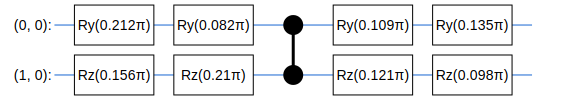

In [21]:
# short-depth discriminator circuit 
def W_circuit(theta, n=2, t=2, l=2):
    qs = [cirq.GridQubit(i,0) for i in range(n)]
    W_circuit = cirq.Circuit()
    for layer in range(l):
        W_circuit.append(W_help(theta, n, t, qs, layer, l))
    return W_circuit

# theta = np.random.rand(l,n,t)
theta = np.random.rand(8)
SVGCircuit(W_circuit(theta, 2, 2, 2))

## 3. Binary label classification in the X-Z plane of the Bloch Sphere

We will apply now test our two-qubit variational circuit for a binary classification task. In this task, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets. 

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere. For testing purposes, we also generate data-sets for binary classification on a number-line, and on the unit-circle.

### a.  Generate dataset and apply feature map

In [22]:
def number_line_data(num_samples):
    q_data = []
    labels = []
    for _ in range(num_samples):
        coin = random.random()
        q_data.append(coin)
        if coin > 0.5:
            labels.append(1)
        else:
            labels.append(0)
    return np.array(q_data), np.array(labels)

In [23]:
def thetas(n, t0=0):
    dtheta = 2 * np.pi / n
    return t0 + np.array([i*dtheta for i in range(n)])

In [24]:
def unit_circle_data(t, n, t0=0):      
    T = (np.tile([0]*n, (t,1)) + 
    np.array([np.array([np.cos(theta), np.sin(theta)]) for theta in thetas(t, t0)]))
    ys = np.array([[1,0]]*int(np.floor(t/2)) + [[0,1]]*int(np.ceil(t/2)))
        
    return T, ys

In [25]:
def unit_sphere_data(theta_a, theta_b, num_samples):
    q_data = []
    bloch = {"a": [[], [], []], "b": [[], [], []]}
    labels = []
    blob_size = abs(theta_a - theta_b) / 5
    for _ in range(num_samples):
        coin = random.random()
        spread_x = np.random.uniform(-blob_size, blob_size)
        spread_y = np.random.uniform(-blob_size, blob_size)
        if coin < 0.5:
            label = [1,0]
            angle = theta_a + spread_y
            source = "a"
        else:
            label = [0,1]
            angle = theta_b + spread_y
            source = "b"
        labels.append(label)
        q_data.append([angle, spread_x])
        bloch[source][0].append(np.cos(angle))
        bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
        bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
    return np.array(q_data), np.array(labels), bloch

In [26]:
# vector label to scalar label 
def get_label(v):
    if (v[0] == 1):
        return 1
    elif (v[0] == 0):
        return -1
    else:
        return "error"

In [27]:
# convert classical data to quantum data using feature map circuit
def convert_to_circuit(x, n=2):
    qs = [cirq.GridQubit(i,0) for i in range(n)]
    circuit = cirq.Circuit()
    circuit.append(feature_map(x, 2))
    return circuit

In [28]:
def map_plus_tf(c_data):  
    x_circ = []
    for j in range(len(c_data)):
        circuit_rep = convert_to_circuit(c_data[j])
        x_circ.append(circuit_rep)
        
    x_tfcirc = tfq.convert_to_tensor(x_circ)
   
    return x_tfcirc 

### b.  Training phase

In [29]:
# returns a bit string {0,1}^n corrensponding to the result of a measurement in the Z-basis
# x = training samples, theta = values of the variational parameters
def measure(x, R, theta, n=2):
    circuit = cirq.Circuit()
    qs = [cirq.GridQubit(i, 0) for i in range(n)]
    circuit.append(feature_map(x, n))
    W_circuit = cirq.Circuit()
    for layer in range(2):
        W_circuit.append(W_help(theta, n, 2, qs, layer, 2))
    circuit.append(W_circuit)
    
    sampler = cirq.Simulator()
    run_circuit = cirq.Circuit(circuit, cirq.measure(qs[0], qs[1], key='out'))
    measurement = sampler.run(run_circuit, repetitions=R)
    return measurement

The function $f : \{0,1\}^n \rightarrow C$ is fixed and chosen by the programmer.

In [30]:
# returns 1 (0) if z is even (odd)
def f(z):
    if z==2:
        return 1
    return 0 # represents -1

In [31]:
# returns measurement probility distribution pd = (py(-1), py(+1)) for
# data vector x and parameters theta
def prob_dist(x, R, theta, C=[-1,+1]):
    
    res = measure(x, R, theta)
    probs = np.zeros(len(C))
    
    hist = res.histogram(key="out")
    for k in hist.keys():
        classification = f(k) # classification function f defined by programmer
        probs[classification] += hist[k]
    
    p0 = probs[0] / R    # probability of -1 measurement
    p1 = probs[1] / R    # probability of +1 measurement
    
    return (p0, p1)

The probability that the label $m(\textbf{x}) = y$ is assigned incorrectly is approximated by

$$ \text{Pr}(\tilde{m}(\textbf{x}) \neq m(\textbf{x})) \approx \text{sig}\bigg( \frac{\sqrt{R}\big( \frac{1}{2} - \big( \hat{p}_y(\textbf{x})+ \frac{yb}{2} \big) \big)}{\sqrt{2(1-\hat{p}_y(\textbf{x}))\hat{p}_y(\textbf{x})}} \bigg) $$ 

where $\text{sig}(x) = (1+ e^{-x})^{-1}$ is the sigmoid function.

In [32]:
def sig(x): 
    return (1/(1+np.exp(-x)))

In [33]:
# error probablility
def prob_incorrect(R, pd, y, b=0):
    if y == -1:
        py = pd[0]
    elif y == 1:
        py = pd[1]
    else: 
        assert False, "expected y in {-1,+1}"
    n = np.sqrt(R)*(1/2.-(py+y*b/2.))
    d = np.sqrt(2*(1-py)*py)
    if d == 0:
        return 0
    return sig(n/d)

We define the empirical risk $R_{\text{emp}}(\theta)$ in terms of the error probability $\text{Pr}(\tilde{m}(\textbf{x} \neq m(\textbf{x}))$ of assigning the incorrect label, based on the decision rule $\tilde{m}(\textbf{s}) = \text{argmax}_y\{ \hat{p}_y(\textbf{s}) \}$ after R shots, averaged over the samples in the training set $T$. In the binary case this decision rule simplifies to $\tilde{m}(\textbf{x}) = y$ whenever $\hat{p}_y(\textbf{x}) > \hat{p}_{-y}(\textbf{x}) - yb$.

$$ R_{\text{emp}}(\theta) = \frac{1}{|T|} \sum_{\textbf{x} \in T} \text{Pr}(\tilde{m}(\textbf{x}) \neq m(\textbf{x})).$$

In [34]:
def Remp(x, y, R, T, theta):
    risk = 0.0
    for i in range(T):
        try:
            pd = prob_dist(x[i], R, theta)
        except ValueError:
            return -1
        pi = prob_incorrect(R, pd, get_label(y[i]))
        risk += pi
    return risk/T

In [35]:
# SPSA (simultaneous perturbation stochastic approximation) to optimize theta
def SPSA(N, R, a, A, c, alpha, gamma, theta):
    p = len(theta) # dimension for random perturbation vector
    risk = []
    for k in range(1,N):
        if (100*k/N)%20 == 0:
            print(str(100*k/N)+"%...")
        ak = a/((A+k)**alpha)
        ck = c/(k**gamma)
        delta = 0.2*np.around(np.random.rand(1,p),2)-1
        thetaplus = theta+(ck*delta)
        thetaminus = theta-(ck*delta)
        yplus = Remp(q_data, labels, R, num_samples, thetaplus[0])
        yminus = Remp(q_data, labels, R, num_samples, thetaminus[0])
        if yplus - yminus == 0:
            pass
        elif (yplus == -1 or yminus == -1):
            pass
        else:
            for i,x in enumerate(delta[0]):
                if x == 0:
                    print("got here oops")
                    delta[0][i] = 1e-2
            ghat = (yplus - yminus)/(2*ck*delta)
            theta = theta-ak*ghat
            risk.append(yplus)
    print("Done")
    return theta, risk

In [36]:
def adjust_param(R, delta, i, theta):
    thetaplus = theta.copy()
    thetaminus = theta.copy()
    thetaplus[i*2] += delta
    thetaplus[i*2+1] += delta
    thetaminus[i*2] -= delta
    thetaminus[i*2+1] -= delta    
    y = Remp(q_data, labels, R, num_samples, theta)
    yplus = Remp(q_data, labels, R, num_samples, thetaplus)
    yminus = Remp(q_data, labels, R, num_samples, thetaminus)
    if (yplus < y and yplus < yminus and yplus != -1):
        #print("i = " + str(i) + " returning yplus, theta = " + str(thetaplus))
        return thetaplus, yplus
    elif (yminus < y and yminus < yplus and yminus != -1):
        #print("i = " + str(i) + " returning yminus, theta = " + str(thetaminus))
        return thetaminus, yminus
    else:
        #print("i = " + str(i) + " returning original, theta = " + str(theta))
        return theta, y

In [37]:
def optimize_theta(N, R, delta, i, theta, risk):
    if N == 0:
        return theta, risk
    else:
        theta_new, risk_new = adjust_param(R, delta, i, theta)
        if i == (len(theta)/2)-1:
            #print("N = " +  str(N-1))
            #print("theta = " + str(theta))
            risk_copy = risk.copy()
            risk_copy.append(risk_new)
            return optimize_theta(N-1, R, delta, 0, theta_new, risk_copy)
        else:
            return optimize_theta(N, R, delta, i+1, theta_new, risk)
        

In [38]:
# initialize needed variables and coefficients
qubit = cirq.GridQubit(0,0)

theta0 = np.random.rand(8) # initialize parameters to be trained
N = 100 # number of iterations
R = 10 # number of measurement shots
num_samples = 20
n = 2
a = 1e-9 
A = 10
c = 1e-6
alpha = 0.1
gamma = 10

delta = 0.01

# shuffler = np.random.permutation(len(q_data))
# q_data = q_data[shuffler]
# labels = labels[shuffler]

In [39]:
#theta_prime, risk = optimize_theta(N, R, delta, 0, theta0, [])

In [40]:
#theta_prime, risk = SPSA(N, R, a, A, c, alpha, gamma, theta0) # new optimized thetas

In [41]:
def build_model(i):
    
    a,b,c,d,e,f,g,h = sympy.symbols('a b c d e f g h')
    theta0 = sympy.Matrix([a,b,c,d,e,f,g,h])
    q_model = cirq.Circuit()
    q_model.append(W_circuit(theta0))
    q_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    measure_z = tfq.layers.PQC(q_model, cirq.Z(qubit))
    measure_zout = measure_z(q_data_input)
    
    weights = "cp"+str(i)+".cpkt"
    checkpoint_path = "training/"+weights
    checkpoint_dir = os.path.dirname(checkpoint_path)

    classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.sigmoid)
    classifier_output = classifier(measure_zout)
    model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    
    return model, checkpoint_path

In [42]:
def train_help(train_data, train_labels, epochs, i, N):
    
    x_train_tfcirc = map_plus_tf(expand(train_data))
    model, checkpoint_path = build_model(i)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=0)
    history = model.fit(x=x_train_tfcirc, y=expand(train_labels), epochs=epochs, verbose=0, callbacks=[cp_callback])
    
    progress = 100*(i+1)/N
    if (progress%10 == 0):
        print(str(progress)+"%...")
    
    return checkpoint_path, history.history['loss']

In [43]:
def train(train_data, train_labels, epochs):
    N = len(train_data)
    assert(N == len(train_labels))
    hst = []
    print("progress: ")
    for i in range(N):
        checkpoint_path, history = train_help(train_data[i], train_labels[i], epochs, i, N)
        hst.append((checkpoint_path, history))
    return hst

### c. Classification phase

In [44]:
def classify(x, y, R, theta_prime):
    count_correct = 0
    for i in range(len(x)):
        pd = prob_dist(x[i], R, theta_prime)
        label = np.argmax(pd)
        if label == y[i][0]:
            count_correct +=1
    return count_correct/(len(x))

In [45]:
def test(test_data, test_labels, hst):
    N = len(test_data)
    assert(N == len(test_labels))
    accuracy = []
    error = []
    for i in range(N):
        path = hst[i][0]
        x_test_tfcirc = map_plus_tf(expand(test_data[i]))
        model, _ = build_model(i)
        model.load_weights(path)
        result = model.evaluate(x_test_tfcirc, expand(test_labels[i]), verbose=0)
        accuracy.append(result[1])
        error.append(hst[i][1])
    return sum(accuracy)/N, lst_average(error)

In [46]:
grid search for optimal parameters
params = [0.0001, 0.1, 10]
best = 0.0
second_best = 0.0
optimal_params = [0,0,0,0,0]
second_params = [0,0,0,0,0]
progress = 0
for a in [1e-9, 1e-6, 1e-3]:
    for A in [10, 100]:
        for c in [1e-9, 1e-6, 1e-3]:
            for alpha in [0.001, 0.1, 1]:
                for gamma in [0.0001, 0.1, 10]:
                    theta_prime = SPSA(N, R, a, A, c, alpha, gamma, theta0)[0]
                    accuracy = classify(q_data, labels, 10, theta_prime)
                    if accuracy > best:
                        best = accuracy
                        optimal_params = [a, A, c, alpha, gamma]
                    elif accuracy > second_best:
                        second_best = accuracy
                        second_params = [a, A, c, alpha, gamma]
                    #progress += 1
                    #if progress%27 == 0:
                        #print(str(100*progress/162)+"%...")
# print("best="+str(best))
# print(optimal_params)
# print("second best="+str(second_best))
# print(second_params)

In [47]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Test on unit-circle

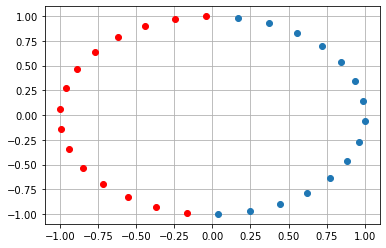

In [48]:
circle_data, circle_labels = unit_circle_data(t=30,n=2,t0=-np.pi/2+0.04)

x_blue = []
y_blue = []
x_red = []
y_red = []
for i in range(len(circle_data)):
    if circle_labels[i][0] == 0:
        x_red.append(circle_data[i][0])
        y_red.append(circle_data[i][1])
    else:
        x_blue.append(circle_data[i][0])
        y_blue.append(circle_data[i][1])

plt.plot(x_red, y_red,'o', color="red")
plt.plot(x_blue, y_blue,'o')
plt.grid()
plt.savefig('unit_circle')
plt.show()

In [49]:
history = train(circle_data, circle_labels, epochs=30)

progress: 
10.0%...
20.0%...
30.0%...
40.0%...
50.0%...
60.0%...
70.0%...
80.0%...
90.0%...
100.0%...


In [50]:
accuracy, error = test(circle_data, circle_labels, history)
print("accuracy = "+str(accuracy))

accuracy = 1.0


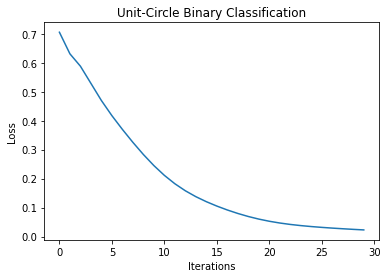

In [51]:
plt.plot(error)
plt.title("Unit-Circle Binary Classification")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig('Unit_Circle_Classification')
plt.show()

Test on unit-sphere

In [52]:
theta_a = 1
theta_b = 4
num_samples = 50
bloch_data, bloch_labels, bloch_p = unit_sphere_data(theta_a, theta_b, num_samples)
bloch_data_test, bloch_labels_test, _, = unit_sphere_data(theta_a, theta_b, num_samples)

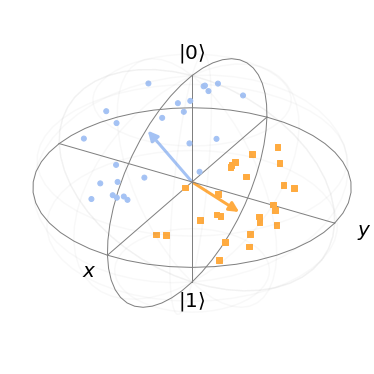

In [53]:
# View the dataset on the Bloch sphere using qutip
bloch = qutip.Bloch()
bloch.sphere_alpha = 0.0
bloch.frame_alpha = 0.05
bloch.vector_color[0] = bloch.point_color[0] = "#a4c2f4ff"
bloch.vector_color[1] = bloch.point_color[1] = "#ffab40ff"
bloch.add_points(bloch_p["a"])
bloch.add_points(bloch_p["b"])
vec = [[np.cos(theta_a),0,np.sin(theta_a)]]
bloch.add_vectors(vec)
vec = [[np.cos(theta_b),0,np.sin(theta_b)]]
bloch.add_vectors(vec)
bloch.show()

In [54]:
history = train(bloch_data, bloch_labels, epochs=30)

progress: 
10.0%...
20.0%...
30.0%...
40.0%...
50.0%...
60.0%...
70.0%...
80.0%...
90.0%...
100.0%...


In [55]:
accuracy, error = test(bloch_data, bloch_labels, history)
print("accuracy = "+str(accuracy))

accuracy = 0.98


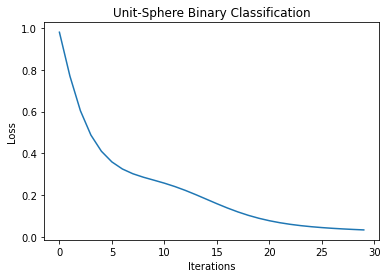

In [56]:
plt.plot(error)
plt.title("Unit-Sphere Binary Classification")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig('Unit_Sphere_Classification')
plt.show()

## 4. Binary label classification for two numbers from the MNIST dataset

Future work

In [ ]:
# load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

In [ ]:
# With one readout bit we cannot label ten digits so instead we pick two digits, say 3 and 6. So filter dataset 
# to keep just 3s and 6s and convert label (y) to boolean: 3=True, 6=False
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

In [ ]:
# Show first example
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [ ]:
# Can only easily handle say 16 bit data using a classical simulator of a 17 qubit quantum computer with one 
# readout bit, so resize images from 28x28 to 4x4
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [ ]:
# Show first example after resize
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# Filter the dataset to remove images that are labeled as belonging to both classes, as suggested in Farhi et al. 
# Section 3.3 Learning to Distinguish Digits. Note: this filtering will not totally prevent the model from 
# receiving contradictory training examples.
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
        labels = mapping[tuple(x.flatten())]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(labels.pop())
        else:
            # Throw out images that match more than one label.
            pass

    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

In [ ]:
# To process images using a quantum computer, represent each pixel with a qubit, with the state depending on
# the value of the pixel. First, convert to a binary encoding.
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
# def convert_to_circuit(image, n=4):
#     x = image.flatten()
#     qs = [cirq.GridQubit(i, 0) for i in range(n)]
#     circuit = cirq.Circuit()
#     circuit.append(feature_map(x, 4))
#     circuit.append(W_circuit)
#     return circuit

In [ ]:
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
# x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
# x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
tfq.util.get_supported_gates()